# Data descriptions
## Train/Test 
- **store_nbr**: Store ID
- **family**: type of product sold
- **sales**: total sales of type for that day
- **onpromotion**: number of items being promoted at a store for that day
- Test set contains data for 15 days after the last date of the train set
  - Train: 01/01/2013 - 08/15/2017
  - Test: 08/16/2017 - 08/31/2017

## Stores
- Store metadata - city, state, type, and cluster
- Cluster is a grouping of similar stores (not clear by what characteristics)

## Oil
- Daily oil price - Ecuador is dependent on oil
- Economical health is highly vulnerable to shocks in oil prices

## Holiday Events
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

## Transactions
- No 'official' description but it seems to be total number of transactions for a specific store for that given day

## Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Initialize modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from pathlib import Path

In [5]:
# Load Kaggle data sets
path = Path('drive/MyDrive/store-sales-time-series-forecasting')  # Remember to update

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

train = pd.read_csv(
    path / 'train.csv',
    dtype = dtype,
    parse_dates=['date'],  # changes date data type to datetime64 [ns]
    infer_datetime_format=True  # Can improve parsing speed up to 5-10x
)

test = pd.read_csv(
    path / 'test.csv',
    dtype = dtype,
    parse_dates=['date'],  
    infer_datetime_format=True  
)

stores = pd.read_csv(
    path / 'stores.csv'
)

oil = pd.read_csv(
    path / 'oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True
)

holidays_events = pd.read_csv(
    path / 'holidays_events.csv',
    parse_dates=['date'],
    infer_datetime_format=True
)

transactions = pd.read_csv(
    path / 'transactions.csv',
    parse_dates=['date'],
    infer_datetime_format=True
)

sample = pd.read_csv(path / 'sample_submission.csv')


# 1. Linear Regression with Time Series

In [6]:
# Set indexes
store_sales = train.set_index('date').to_period('D') # Allows datetime index to be segmented by day, week, month, year
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True) # append is needed to maintain the date index
average_sales = store_sales.groupby('date').mean()['sales']

In [7]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

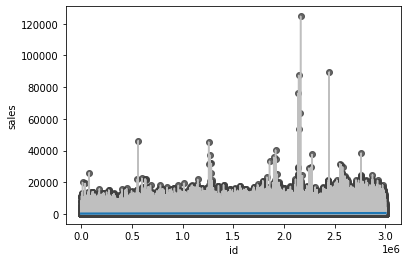

In [17]:
fig, ax = plt.subplots()
ax.plot('id', 'sales', data=store_sales, color='0.75')
ax = sns.regplot(x='id', y='sales', data=store_sales, ci=None, scatter_kws=dict(color='0.25'))


## Fit a time-step feature

In [62]:
df = average_sales.to_frame()

df['time'] = np.arange(len(df.index))

X = df.loc[:,['time']]
y = df.loc[:,'sales']
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

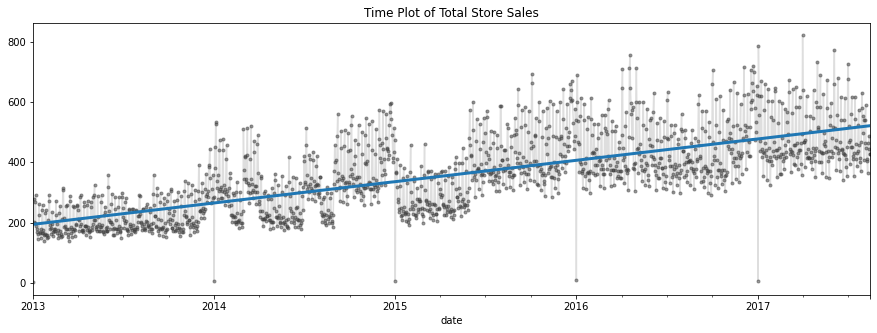

In [63]:
plot_params = {
    'color' : '0.75',
    'style' : '.-',
    'markeredgecolor' : '0.25',
    'markerfacecolor' : '0.25',
    'legend' : False,
}

plt.rcParams['figure.figsize'] = [15, 5]

ax = y.plot(**plot_params,alpha=0.5)
ax = y_pred.plot(linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

## Fit a lag feature to store sales

In [68]:
df['lag_1'] = df['sales'].shift(1)

X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

[Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'lag_1'),
 Text(0.5, 1.0, 'Lag Plot of Average Sales'),
 None]

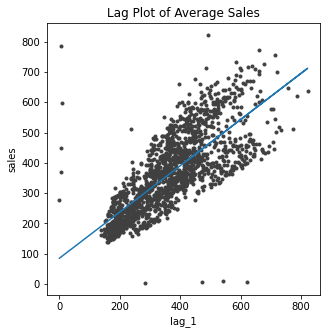

In [77]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales')

# 2. Trend